# Python intro

gdsfactory is written in python and requires some basic knowledge of python.

If you are new to python you can find many resources online

- [books](https://jakevdp.github.io/PythonDataScienceHandbook/index.html)
- [youTube videos](https://www.youtube.com/c/anthonywritescode)
- [courses](https://github.com/joamatab/practical-python)

This notebook is for you to experiment with some common python patterns in `gdsfactory`

## Classes

Gdsfactory has already some pre-defined classes for you. The only class you may need to define is a Layermap. Which can be easily defined as a `dataclass`

All the other classes (Component, ComponentReference, Port ...) are already available in `gf.typings`

Classes are good for keeping state, which means that they store some information inside them (polygons, ports, references ...)

In [1]:
from pydantic import validate_arguments

import gdsfactory as gf

PDK = gf.get_generic_pdk()
PDK.activate()

c = gf.Component(name="my_fist_class")
c.add_polygon([(-8, 6, 7, 9), (-6, 8, 17, 5)], layer=(1, 0))
c

2023-02-20 17:52:10.334 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.43.1


2023-02-20 17:52:11.193 | INFO     | gdsfactory.technology.layer_views:__init__:785 - Importing LayerViews from YAML file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/layer_views.yaml.


2023-02-20 17:52:11.200 | INFO     | gdsfactory.pdk:activate:206 - 'generic' PDK is now active


AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

my_fist_class: uid ad0c6829, ports [], references [], 1 polygons


## Functions

Functions have clear inputs and outputs, they usually accept some parameters (strings, floats, ints ...) and return other parameters

In [2]:
def double(x):
    return 2 * x


x = 1.5
y = double(x)
print(y)

3.0


It's also nice to add `type annotations` to your functions to clearly define what are the input/output types (string, int, float ...)

In [3]:
def double(x: float) -> float:
    return 2 * x

## Factories

A factory is a function that returns an object. In gdsfactory many functions return a `Component` object

bend_euler_radius10: uid 760ba2eb, ports ['o1', 'o2'], references [], 1 polygons


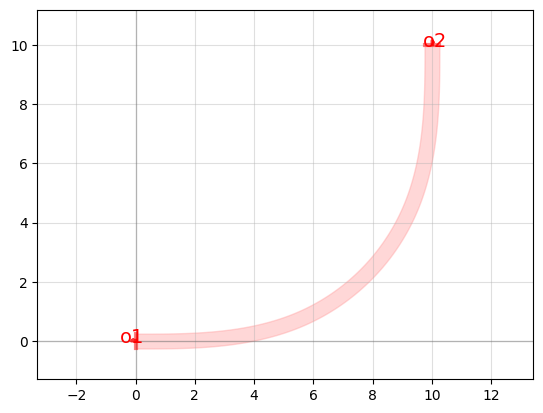

In [4]:
def bend(radius: float = 5) -> gf.typings.Component:
    return gf.components.bend_euler(radius=radius)


component = bend(radius=10)

print(component)
component.plot()

In [5]:
component

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

bend_euler_radius10: uid 760ba2eb, ports ['o1', 'o2'], references [], 1 polygons


## Decorators

gdsfactory has many functions, and we want to do some common operations for the ones that return a Component:

- give a unique name (dependent on the input parameters) to a Component
- validate input arguments based on type annotations
- cache the Component that the function returns for speed and reuse cells.

For that you will see a `@cell` decorator on many component functions.

The validation functionality comes from the [pydantic](https://pydantic-docs.helpmanual.io/) package
and is available to you automatically when using the `@cell` decorator

In [6]:
@validate_arguments
def double(x: float) -> float:
    return 2 * x


x = 1.5
y = double(x)
print(y)

3.0


The validator decorator is equivalent to running

In [7]:
def double(x: float) -> float:
    return 2 * x


double_with_validator = validate_arguments(double)
x = 1.5
y = double_with_validator(x)
print(y)

3.0


The `cell` decorator also leverages that validate arguments.
So you should add type annotations to your component factories.

Lets try to create an error `x` and you will get a clear message the the function `double` does not work with strings

```python
y = double("not_valid_number")
```

will raise a `ValidationError`

```
ValidationError: 0 validation error for Double
x
  value is not a valid float (type=type_error.float)

```

It will also `cast` the input type based on the type annotation. So if you pass an `int` it will convert it to `float`

In [8]:
x = 1
y = double_with_validator(x)
print(y, type(x), type(y))

2.0 <class 'int'> <class 'float'>


## List comprehensions

You will also see some list comprehensions, which are common in python.

For example, you can write many loops in one line

In [9]:
y = []
for x in range(3):
    y.append(double(x))

print(y)

[0, 2, 4]


In [10]:
y = [double(x) for x in range(3)]  # much shorter and easier to read
print(y)

[0, 2, 4]


## Functional programming

Functional programming follows linux philosophy:

- Write functions that do one thing and do it well.
- Write functions to work together.
- Write functions with clear **inputs** and **outputs**

### partial

Partial is an easy way to modify the default arguments of a function. This is useful in gdsfactory because we define PCells using functions.

`gdsfactory.partial` comes from the module `functools.partial`, which is available in the standard python library.

The following two functions are equivalent in functionality.

Notice how the second one is shorter, more readable and easier to maintain thanks to `gf.partial`

In [11]:
def ring_sc(gap=0.3, **kwargs):
    return gf.components.ring_single(gap=gap, **kwargs)


ring_sc = gf.partial(gf.components.ring_single, gap=0.3)

As you customize more parameters, it's more obvious that the second one is easier to maintain

In [12]:
def ring_sc(gap=0.3, radius=10, **kwargs):
    return gf.components.ring_single(gap=gap, radius=radius, **kwargs)


ring_sc = gf.partial(gf.components.ring_single, gap=0.3, radius=10)

### compose

`gf.compose` combines two functions into one.

In [13]:
ring_sc = gf.partial(gf.components.ring_single, radius=10)
add_gratings = gf.routing.add_fiber_array

ring_sc_gc = gf.compose(add_gratings, ring_sc)
ring_sc_gc5 = ring_sc_gc(radius=5)
ring_sc_gc5

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

ring_single_radius5_add_ed2f50b0: uid f67c0233, ports ['opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-o1', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-o2', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-loopback0', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-loopback1'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4', 'ring_single_1'], 0 polygons


In [14]:
ring_sc_gc20 = ring_sc_gc(radius=20)
ring_sc_gc20

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

ring_single_radius20_ad_a4e6294c: uid 4490bf96, ports ['opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius20-o1', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius20-o2', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius20-loopback0', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius20-loopback1'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4', 'ring_single_1'], 0 polygons


This is equivalent and more readable than writing

In [15]:
ring_sc_gc5 = add_gratings(ring_sc(radius=5))
ring_sc_gc5

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

ring_single_radius5_add_ed2f50b0: uid f67c0233, ports ['opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-o1', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-o2', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-loopback0', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-loopback1'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4', 'ring_single_1'], 0 polygons


In [16]:
ring_sc_gc20 = add_gratings(ring_sc(radius=20))
ring_sc_gc20

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

ring_single_radius20_ad_a4e6294c: uid 4490bf96, ports ['opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius20-o1', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius20-o2', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius20-loopback0', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius20-loopback1'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4', 'ring_single_1'], 0 polygons


In [17]:
print(ring_sc_gc5)

ring_single_radius5_add_ed2f50b0: uid f67c0233, ports ['opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-o1', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-o2', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-loopback0', 'opt-grating_coupler_ellipti_dd7f7af4-ring_single_radius5-loopback1'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4', 'ring_single_1'], 0 polygons


## Ipython

This Jupyter Notebook uses an Interactive Python Terminal (Ipython). So you can interact with the code.

For more details on Jupyter Notebooks, you can visit the [Jupyter website](https://jupyter.org/).

The most common trick that you will see is that we use `?` to see the documentation of a function or `help(function)`

In [18]:
gf.components.coupler?

In [19]:
help(gf.components.coupler)

Help on function coupler in module gdsfactory.components.coupler:

coupler(gap: 'float' = 0.236, length: 'float' = 20.0, coupler_symmetric: 'ComponentSpec' = <function coupler_symmetric at 0x7fe141c053a0>, coupler_straight: 'ComponentSpec' = <function coupler_straight at 0x7fe141c051f0>, dy: 'float' = 5.0, dx: 'float' = 10.0, cross_section: 'CrossSectionSpec' = 'strip', **kwargs) -> 'Component'
    Symmetric coupler.
    
    Args:
        gap: between straights in um.
        length: of coupling region in um.
        coupler_symmetric: spec for bend coupler.
        coupler_straight: spec for straight coupler.
        dy: port to port vertical spacing in um.
        dx: length of bend in x direction in um.
        cross_section: spec (CrossSection, string or dict).
        kwargs: cross_section settings.
    
    .. code::
    
               dx                                 dx
            |------|                           |------|
         o2 ________                           ___

To see the source code of a function you can use `??`

In [20]:
gf.components.coupler??

To see which variables you have defined in the workspace you can type `whos`

To time the execution time of a cell, you can add a `%time` on top of the cell

In [21]:
%time


def hi():
    print("hi")


hi()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs
hi


For more Ipython tricks you can find many resources available online